<center>
    <h1>URBASPACE - SIGHT LINES</h1>
    <h2>PLOT Indicators</h2>
    <h3 style = 'color:#FF5733'>Compute sightline PLOT indicators</h3>        
</center>
<hr/>


In [1]:
import sys; sys.path.append('..')
import datetime
import math
import pandas as pd
import matplotlib.pyplot as plt
import time
import geopandas as gpd
import gc
import seaborn as sns
import gc
import numpy as np
import toml
import os 
import sklearn

from rtree import index as rtree_index
from shapely.ops import unary_union
from shapely.geometry import Point,Polygon,MultiPoint,MultiLineString,LineString,box
from sklearn.cluster import DBSCAN
from datetime import datetime as dt


## Closed-source

# from kinaxia.utils import ProgressBar
# import kinaxia.urbaspace.caches
# from kinaxia.datasets.postgis import *
# from kinaxia.geometry import *
# import kinaxia.constants as constants

# Configuration - Zone

In [3]:
PARAM_insee_layer_name,PARAM_insee_code = 'samples','place_de_gaulle'

# Configuration - General parameters

In [4]:
PARAM_default_street_width = 3

PARAM_tan_line_width=300
PARAM_sight_line_width=50
PARAM_sight_line_spacing=3
PARAM_sight_line_junction_size = 0.5
PARAM_sight_line_angle_tolerance = 5

SIGHTLINE_LEFT  = 0
SIGHTLINE_RIGHT = 1
SIGHTLINE_FRONT = 2
SIGHTLINE_BACK = 3


PARAM_sight_line_plot_depth_extension = 300 # meter of extension to compute depth of plot

In [5]:
fs_cache = kinaxia.urbaspace.caches.FileSystemCache(config['urbaspace']['path_to_caches'])

# DATA - Load road network (from cached geometries)

[==================================================] 100% (0 s) DONE.e convex_hull buffer at @50 meters  ...

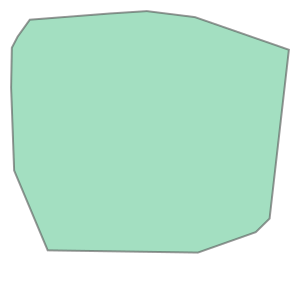

In [7]:
progress = ProgressBar(3)

progress.progress_step('Loading roads geometries ...')
filename = f'{PARAM_insee_layer_name}_{PARAM_insee_code}_sightlines_road_network_dataframe'
gdf_streets = fs_cache.load_pickle('road_sightlines',filename)


progress.progress_step(f'Compute convex_hull buffer at @{PARAM_sight_line_width} meters  ...')
# EXTENDS roads points/nodes to buffer size by computing convex hull of all streets
points = []
for i,res in gdf_streets.iterrows():
    for pt in res.geometry.coords:
        points.append(pt) 
mpt = MultiPoint(points)
hull = mpt.convex_hull


progress.progress_step(f'DONE.')

plot_extension_area =  hull.buffer(PARAM_sight_line_width)

display(hull)
del points
del gdf_streets

# DATA - Load Plot (Parcels)
* Add buffer corresponding to possible plots around each roads at signtline width

In [8]:
progress = ProgressBar(2)
progress.progress_step('POSTGIS fecth - Parcels ...')
gdf_parcels = load_postgis_objects_from_area(postgres_create_engine(config, 'cadastre'),
                                        postgres_table_name(config, 'cadastre', 'parcels'),
                                        plot_extension_area,
                                        constants.PROJECTION_L93,
                                        id_field='id',
                                        geometry_field='geometry',
                                        other_fields=['contenance'],
                                        external_join_mapping=None,
                                        verbose_function=None)

gdf_parcels['parcel_id']=gdf_parcels.index
progress.progress_step(f'POSTGIS - {len(gdf_parcels)} items fetched')
display(gdf_parcels)

[==================================================] 100% (0 s) POSTGIS - 1673 items fetched

,contenance,geometry,parcel_id
id,,,
06004000AY0210,10992,"POLYGON ((1032620.072 6284755.545, 1032628.419...",06004000AY0210
06004000AY0041,665,"POLYGON ((1032809.503 6284871.256, 1032814.058...",06004000AY0041
06004000AY0053,90,"POLYGON ((1032620.417 6284756.521, 1032622.571...",06004000AY0053
06004000AY0208,17,"POLYGON ((1032721.150 6284834.867, 1032721.376...",06004000AY0208
06004000AY0209,4414,"POLYGON ((1032717.120 6284866.341, 1032714.979...",06004000AY0209
...,...,...,...
06004000BL0494,588,"POLYGON ((1032646.581 6284667.739, 1032644.344...",06004000BL0494
06004000BL0548,221,"POLYGON ((1032650.788 6284696.405, 1032642.972...",06004000BL0548
06004000BL0546,255,"POLYGON ((1032648.987 6284684.247, 1032635.769...",06004000BL0546


 # DATA - Load sightlines cache

In [12]:

df_sightlines = fs_cache.load_pickle('road_sightlines',f'{PARAM_insee_layer_name}_{PARAM_insee_code}_sightlines_geometries_dataframe')

# Drop columns ensuring memory is realsed
columns_to_keep = ['uid',
                   'street_length',
                   'sight_line_points',
                   'left_OS_count',
                   'left_SEQ_OS_endpoints',
                   'right_OS_count',
                   'right_SEQ_OS_endpoints']
all_columns=list(df_sightlines)
for col in all_columns:
    if not col in columns_to_keep:
        del df_sightlines[col]

display(f'{len(df_sightlines)} roads')
display(df_sightlines.head(100).transpose())

'259 roads'

uid,74333209,74333266,74333495,74333183,74333354,74333180,74333267,74333312,74333399,74333396,...,74333515,74331097,74331098,74333279,74333305,74333321,74333335,74333387,74333394,74333412
sight_line_points,"[(1033238.2960255673, 6284485.537082302), (103...","[(1033244.0937648923, 6284573.121283858), (103...","[(1033266.3416590712, 6284371.534939623), (103...","[(1033280.2085144464, 6284588.491880089), (103...","[(1033237.7756387232, 6284485.100593824), (103...","[(1033260.4243537567, 6284313.08051891), (1033...","[(1033280.2415025405, 6284355.951460803), (103...","[(1033239.9787836052, 6284536.900450339), (103...","[(1033237.3536001616, 6284391.569085904), (103...","[(1033228.6031939371, 6284271.397584503), (103...",...,"[(1032745.9928408031, 6284644.8097907845), (10...","[(1032876.2870080763, 6284727.613239276), (103...","[(1032891.2860610345, 6284667.317237669), (103...","[(1033026.1464058828, 6284341.189637511), (103...","[(1032746.2807067921, 6284645.585560635), (103...","[(1033119.5429087111, 6284502.297348689), (103...","[(1033081.1413724516, 6284617.865328413), (103...","[(1032776.9158537816, 6284516.375090276), (103...","[(1032770.6872637786, 6284280.009242619), (103...","[(1032970.0284455789, 6284428.955238696), (103..."
left_OS_count,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",...,"[1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1]"
right_OS_count,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 7, 7, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",...,"[1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1]"
left_SEQ_OS_endpoints,"[(1033244.5877952912, 6284535.139639028), (103...","[(1033251.9653791037, 6284622.497773099), (103...","[(1033302.8476967915, 6284405.700846753), (103...","[(1033271.020505578, 6284539.343324739), (1033...","[(1033287.7162562793, 6284482.664466136), (103...","[(1033222.3724628043, 6284345.515894582), (103...","[(1033315.0954222158, 6284320.101714873), (103...","[(1033289.9337497832, 6284534.778810842), (103...","[(1033280.4450097415, 6284416.92910208), (1033...","[(1033188.8447436916, 6284301.716978198), (103...",...,"[(1032775.0137622445, 6284604.093871064), (103...","[(1032864.963080455, 6284776.3140469), (103286...","[(1032879.5622942753, 6284715.923341122), (103...","[(1033047.1826548133, 6284295.830225798), (103...","[(1032697.7246432633, 6284633.656239842), (103...","[(1033139.8080396962, 6284456.588219774), (103...","[(1033044.6085311311, 6284652.002573543), (103...","[(1032789.4068261933, 6284467.960468433), (103...","[(1032729.7630018301, 6284308.735620462), (103...","[(1033014.5045759806, 6284451.799796571), (103..."
right_SEQ_OS_endpoints,"[(1033232.00425

# Spatial index (parcels)

In [13]:
progress = ProgressBar(2)
## Build Spatial indexes
progress.progress_step('RTREE parcels ...')
rtree_parcels = RtreeIndex("parcels", gdf_parcels)
progress.progress_step('RTREE parcels - DONE.')

[==================================================] 100% (0 s) RTREE parcels - DONE.

# per street sighlines indicators

In [23]:
def compute_sigthlines_plot_indicators_one_side(sight_line_points,
                                                OS_count,
                                                SEQ_OS_endpoint):
   
    
        
    
    parcel_SB_count=[]
    parcel_SEQ_SB_ids=[]
    parcel_SEQ_SB=[]
    parcel_SEQ_SB_depth=[]
    
    
    N = len(sight_line_points)
    if N==0:         
        parcel_SB_count=[0 for sight_point in sight_line_points]
        return [parcel_SB_count,
                parcel_SEQ_SB_ids,
                parcel_SEQ_SB,
                parcel_SEQ_SB_depth]
           
    idx_end_point=0
    
             
    for sight_point,os_count in zip(sight_line_points,
                                    OS_count):
        n_sightlines_touching = 0
        for i in range(os_count):
            sight_line_geom = LineString([sight_point,SEQ_OS_endpoint[idx_end_point]])
            s_pt1 = Point(sight_line_geom.coords[0])
            
            gdf_items = gdf_parcels.iloc[rtree_parcels.extract_ids(sight_line_geom)]
            
            match_distance = PARAM_sight_line_width # set max distance if no polygon intersect
            match_id = None
            match_geom = None
            
            
            for i,res in gdf_items.iterrows():   
                # building geom
                geom = res.geometry
                geom = geom if isinstance(geom,Polygon) else geom.geoms[0] 
                contour = LineString(geom.exterior.coords)        
                isect = sight_line_geom.intersection(contour)    
                if not isect.is_empty:        
                    if isinstance(isect,Point):
                        isect=[isect]
                    elif isinstance(isect,LineString):
                        isect = [Point(coord) for coord in isect.coords]
                    elif isinstance(isect,MultiPoint):
                        isect = [pt for pt in isect.geoms]
                        
                    for pt_sec in isect:
                        dist = s_pt1.distance(pt_sec)
                        if dist < match_distance:
                            match_distance = dist                          
                            match_id = res.parcel_id
                            match_geom = geom
            
            #---------------
            # result in intersightline
            if match_id is not None:
                n_sightlines_touching+=1
                parcel_SEQ_SB_ids.append(match_id)
                parcel_SEQ_SB.append(match_distance)
                # compute depth of plot intersect sighline etendue 
                try:
                    if not match_geom.is_valid:
                        match_geom=match_geom.buffer(0)
                    isec = match_geom.intersection(extend_line_end(sight_line_geom,PARAM_sight_line_plot_depth_extension))                                
                    if (not isinstance(isec,LineString)) and (not isinstance(isec,MultiLineString)):
                        display( (not isinstance(isec,LineString)) , (not isinstance(isec,MultiLineString)))
                        raise Exception('Not allowed: intersection is not of type Line')
                    parcel_SEQ_SB_depth.append(isec.length)
                except Exception as e:
                    display(match_geom)
                    display(sight_line_geom)
                    display(f'Parcel[{match_id}] validity: {match_geom.is_valid}')
                    display(sight_line_geom.is_valid)
                    raise e
                            
            #------- iterate
            idx_end_point+=1
        
        parcel_SB_count.append(n_sightlines_touching)

    
    
    
    
    return [parcel_SB_count,
            parcel_SEQ_SB_ids,
            parcel_SEQ_SB,
            parcel_SEQ_SB_depth]
    
    
    
    

In [15]:
#geom =gdf_parcels.loc['060430000A1695'].geometry
#geom.buffer(0).is_valid

# DEBUG/DISPLAY

In [16]:
def DEBUG_plot_road(uid):
    row = df_sightlines.loc[uid]
    sight_line_points=row.sight_line_points
    left_OS_count=row.left_OS_count
    left_SEQ_OS_endpoints=row.left_SEQ_OS_endpoints
    right_OS_count=row.right_OS_count
    right_SEQ_OS_endpoints=row.right_SEQ_OS_endpoints
    
    values=[]
    
    idx_left_end_point=0
    idx_right_end_point=0
     
    for point_id, start_point,left_count,right_count in zip(range(len(sight_line_points)),
                                                            sight_line_points,
                                                            left_OS_count,
                                                            right_OS_count):
        for i in range(left_count):
            values.append([LineString([start_point,left_SEQ_OS_endpoints[idx_left_end_point]]),
                           point_id,
                           SIGHTLINE_LEFT])
            idx_left_end_point+=1
        for i in range(right_count):
            values.append([LineString([start_point,right_SEQ_OS_endpoints[idx_right_end_point]]),
                           point_id,
                           SIGHTLINE_RIGHT])
            idx_right_end_point+=1
                  
    gdf_sight_lines = gpd.GeoDataFrame(values,columns=['geometry','point_id','sight_type'])
 
    geom_bounds = shapely.ops.unary_union(gdf_sight_lines.geometry).buffer(5).exterior
    
    gdf_items = gdf_parcels.iloc[rtree_parcels.extract_ids(geom_bounds)]
    
    sight_points = [Point(line.coords[0]) for line in gdf_sight_lines.geometry.values]
    
    
    # algo 
    side_values = compute_sigthlines_plot_indicators_one_side(
        row.sight_line_points,
        row.left_OS_count,
        row.left_SEQ_OS_endpoints)
    sight_line_values.append(side_values)
    
    
    
    
    fig,ax = plt.subplots(1,1,figsize=(20,20))
    gdf_items.plot(ax=ax,color='lightgray',edgecolor='gray')#column='category', categorical=True,cmap='Pastel2',legend=True,label='category')
    gpd.GeoDataFrame(sight_points,columns=['geometry']).plot(color='black',markersize=50,ax=ax)
    side_color_table=['green','lightblue'] 
    for side_type,side_color in zip([SIGHTLINE_LEFT,SIGHTLINE_RIGHT],side_color_table):
        gdf_side_main = gdf_sight_lines[gdf_sight_lines.sight_type==side_type].drop_duplicates(subset=['point_id'],keep='first')        
        gdf_side_snail = gdf_sight_lines[gdf_sight_lines.sight_type==side_type].drop(gdf_side_main.index)
    
        gdf_side_main.plot(color=side_color,linewidth=1,  ax=ax) if len(gdf_side_main)>0 else None
        gdf_side_snail.plot(color=side_color,linewidth=1,  ax=ax) if len(gdf_side_snail)>0 else None
    
    plt.show()
    
    
    display(gdf_sight_lines)
    
#DEBUG_plot_road(74333382)  # 06
#DEBUG_plot_road(74247563)  # BUG geom 06

# MAIN PROCESS

In [26]:
values=[]

progress_step = 1000 if len(df_sightlines)>=10000 else 10
progress_chunksize = len(df_sightlines)//progress_step
progress = ProgressBar(progress_step)

progress_count=0
for uid,row in df_sightlines.iterrows():   
    
    sight_line_values=[uid]
        
    side_values = compute_sigthlines_plot_indicators_one_side(
        row.sight_line_points,
        row.left_OS_count,
        row.left_SEQ_OS_endpoints)
    sight_line_values += side_values
    
    side_values = compute_sigthlines_plot_indicators_one_side(
        row.sight_line_points,
        row.right_OS_count,
        row.right_SEQ_OS_endpoints)
    sight_line_values += side_values
    
    values.append(sight_line_values)
    if len(values)%progress_chunksize==0:
        progress.progress_step(f'{len(values)}/{len(df_sightlines)} items proceed')
    
    
    

[==================================================] 100% (18 s) 250/259 items proceed

In [27]:
df_results = pd.DataFrame(values,columns=['uid',
                                  'left_parcel_SB_count',
                                  'left_parcel_SEQ_SB_ids',
                                  'left_parcel_SEQ_SB',
                                  'left_parcel_SEQ_SB_depth',
                                  'right_parcel_SB_count',
                                  'right_parcel_SEQ_SB_ids',
                                  'right_parcel_SEQ_SB',
                                  'right_parcel_SEQ_SB_depth'])
df_results= df_results.set_index('uid',drop=False)
display(f'{len(df_results)} items')
display(df_results.head())

'259 items'

,uid,left_parcel_SB_count,left_parcel_SEQ_SB_ids,left_parcel_SEQ_SB,left_parcel_SEQ_SB_depth,right_parcel_SB_count,right_parcel_SEQ_SB_ids,right_parcel_SEQ_SB,right_parcel_SEQ_SB_depth
uid,,,,,,,,,
74333209,74333209,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[06004000BR0301, 06004000BR0561, 06004000BR029...","[40.8573884831226, 20.12202339787249, 0.749169...","[5.617923067980064, 7.280163828084245, 8.22633...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[06004000BR0536, 06004000BR0289, 06004000BR029...","[2.9643066179907294, 2.7615438792789395, 2.558...","[7.413245819936045, 8.144799176446178, 13.1016..."
74333266,74333266,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, ...","[06004000BN0239, 06004000BN0239, 06004000BN023...","[1.2674323114838504, 1.250641945762365, 0.9635...","[18.689363604048868, 18.70047218396521, 18.820...","[0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[06004000BN0241, 06004000BN0241, 06004000BN024...","[1.84941972351995, 1.4431991029774935, 1.43094...","[16.820958484744285, 17.22989053527103, 17.350..."
74333495,74333495,"[1, 1, 1, 1, 1, 1, 1]","[06004000BR0531, 06004000BR0207, 06004000BR020...","[2.6010523556715217, 6.253367019844725, 10.001...","[2.109081178179492, 6.957305316382872, 5.90020...","[1, 1, 1, 1, 1, 1, 1]","[06004000BR0134, 06004000BR0134, 06004000BR013...","[3.339181582674827, 2.465309790258904, 1.73684...","[8.012607450870473, 8.17876725958656, 8.177962..."
74333183,74333183,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[06004000BN0231, 06004000BN0234, 06004000BN023...","[1.6552175584058677, 1.610602123032985, 1.5717...","[15.891510272306075, 16.33954964581101, 16.831...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[06004000BN0054, 06004000BN0059, 06004000BN005...","[20.931199504155597, 1.1631519576139857, 1.142...","[11.862680675267605, 21.05411948058156, 20.856..."
74333354,74333354,"[1, 1, 1, 1, 1, 1, 1, 1]","[06004000BR0294, 06004000BR0289, 06004000BR028...","[23.129534658974503, 0.9671320042817667, 0.805...","[2.1435991354259114, 2.6664433294619228, 2.703...","[0, 1, 1, 1, 1, 1, 1, 1]","[06004000BR0535, 06004000BR0535, 06004000BR053...","[5.44880947155645, 5.792742151469802, 0.924587...","[19.659629717495935, 19.106939563669172, 23.76..."


# Join additionnal street indicators 
Needed to compute street level plot one without reloding all sightline pickle

In [28]:
df_results = df_results.join(df_sightlines[['street_length']])
df_results.head()

,uid,left_parcel_SB_count,left_parcel_SEQ_SB_ids,left_parcel_SEQ_SB,left_parcel_SEQ_SB_depth,right_parcel_SB_count,right_parcel_SEQ_SB_ids,right_parcel_SEQ_SB,right_parcel_SEQ_SB_depth,street_length
uid,,,,,,,,,,
74333209,74333209,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[06004000BR0301, 06004000BR0561, 06004000BR029...","[40.8573884831226, 20.12202339787249, 0.749169...","[5.617923067980064, 7.280163828084245, 8.22633...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[06004000BR0536, 06004000BR0289, 06004000BR029...","[2.9643066179907294, 2.7615438792789395, 2.558...","[7.413245819936045, 8.144799176446178, 13.1016...",34.171626
74333266,74333266,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, ...","[06004000BN0239, 06004000BN0239, 06004000BN023...","[1.2674323114838504, 1.250641945762365, 0.9635...","[18.689363604048868, 18.70047218396521, 18.820...","[0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[06004000BN0241, 06004000BN0241, 06004000BN024...","[1.84941972351995, 1.4431991029774935, 1.43094...","[16.820958484744285, 17.22989053527103, 17.350...",61.693480
74333495,74333495,"[1, 1, 1, 1, 1, 1, 1]","[06004000BR0531, 06004000BR0207, 06004000BR020...","[2.6010523556715217, 6.253367019844725, 10.001...","[2.109081178179492, 6.957305316382872, 5.90020...","[1, 1, 1, 1, 1, 1, 1]","[06004000BR0134, 06004000BR0134, 06004000BR013...","[3.339181582674827, 2.465309790258904, 1.73684...","[8.012607450870473, 8.17876725958656, 8.177962...",21.366329
74333183,74333183,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[06004000BN0231, 06004000BN0234, 06004000BN023...","[1.6552175584058677, 1.610602123032985, 1.5717...","[15.891510272306075, 16.33954964581101, 16.831...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[06004000BN0054, 06004000BN0059, 06004000BN005...","[20.931199504155597, 1.1631519576139857, 1.142...","[11.862680675267605, 21.05411948058156, 20.856...",34.283815
74333354,74333354,"[1, 1, 1, 1, 1, 1, 1, 1]","[06004000BR0294, 06004000BR0289, 06004000BR028...","[23.129534658974503, 0.9671320042817667, 0.805...","[2.1435991354259114, 2.6664433294619228, 2.703...","[0, 1, 1, 1, 1, 1, 1, 1]","[06004000BR0535, 06004000BR0535, 06004000BR053...","[5.44880947155645, 5.792742151469802, 0.924587...","[19.659629717495935, 19.106939563669172, 23.76...",24.629251


# BACKUP sightlines plot values as pickle 

In [32]:
FORCE_BACKUP = False
output_theme='road_sightlines'
output_name = f'{PARAM_insee_layer_name}_{PARAM_insee_code}_sightlines_parcels_dataframe'
if FORCE_BACKUP or not fs_cache.pickle_exists(output_theme,output_name):
    fs_cache.save_to_pickle(df_results,output_theme,output_name)
else:
    display('already exists')

[road_sightlines/samples_place_de_gaulle_sightlines_parcels_dataframe] dataset pickled to W:/DATA/Projects/urbaspace/caches\road_sightlines\samples_place_de_gaulle_sightlines_parcels_dataframe.pickle


# BACKUP plots items (fetched for this run) as pickle 

In [35]:
FORCE_BACKUP = False
output_theme='road_sightlines_helpers'
output_name = f'{PARAM_insee_layer_name}_{PARAM_insee_code}_sightlines_extension_area_for_parcels_geometry'
if FORCE_BACKUP or not fs_cache.pickle_exists(output_theme,output_name):
    fs_cache.save_to_pickle(plot_extension_area,output_theme,output_name)
else:
    display('already exists')

[road_sightlines_helpers/samples_place_de_gaulle_sightlines_extension_area_for_parcels_geometry] dataset pickled to W:/DATA/Projects/urbaspace/caches\road_sightlines_helpers\samples_place_de_gaulle_sightlines_extension_area_for_parcels_geometry.pickle
